In [2]:
import pandas as pd

path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8', index_col=[0])

list(data.columns)

['publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [3]:
import numpy as np

embeddings = np.load('youtube_comments_climate_change/embeddings_transformer.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

print(embeddings)
print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

[[ 0.00309145  0.01158772 -0.03294325 ... -0.03773075 -0.04641611
   0.00654218]
 [ 0.0373652  -0.05704364  0.06250702 ... -0.01463008 -0.00353977
   0.07624619]
 [-0.05214371  0.06868152 -0.01854265 ... -0.04161057  0.00614589
   0.02175345]
 ...
 [ 0.04827696 -0.05136478 -0.03400609 ... -0.02970822  0.01628377
   0.06420484]
 [-0.05631846 -0.02808332  0.01498052 ... -0.06881906 -0.03188506
  -0.00244863]
 [ 0.00809841 -0.05193542  0.05043764 ...  0.0542928   0.04323433
   0.02080319]]
The embeddings vector is of fixed length 512


In [4]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# normalize embeddings
embeddings = normalize(embeddings, norm='l2')

# scale embeddings
sc = StandardScaler()
scaled_embeddings = sc.fit_transform(embeddings)

95% cut-off threshold reached with 328 components.


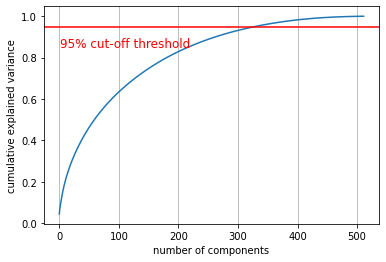

In [5]:
from sklearn.decomposition import PCA
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#with scaling and normalizing
pca_cev = PCA().fit(scaled_embeddings)
cev_plot = np.cumsum(pca_cev.explained_variance_ratio_)
plt.plot(cev_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

print("95% cut-off threshold reached with {} components.".format(np.argwhere(cev_plot >= 0.95)[0][0]))

95% cut-off threshold reached with 325 components.


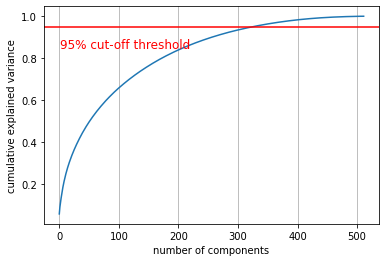

In [25]:
from sklearn.decomposition import PCA
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#without scaling and normalizing
pca_cev = PCA().fit(embeddings)
cev_plot = np.cumsum(pca_cev.explained_variance_ratio_)
plt.plot(cev_plot)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(axis='x')

print("95% cut-off threshold reached with {} components.".format(np.argwhere(cev_plot >= 0.95)[0][0]))

In [31]:
SUBSPACE_DIM_SCALED = 328
SUBSPACE_DIM = 325


pca = PCA(n_components= SUBSPACE_DIM)
scale_pca = PCA(n_components= SUBSPACE_DIM_SCALED)
scaled_pca_embeddings = scale_pca.fit_transform(scaled_embeddings)
pca_embeddings = pca.fit_transform(embeddings)

print("Dimensions of embeddings matrix after PCA with no scaling and normalizing: ({}, {})".format(pca_embeddings.shape[0], pca_embeddings.shape[1]))
print("Dimensions of embeddings matrix after PCA with scaling and normalizing: ({}, {})".format(scaled_pca_embeddings.shape[0], scaled_pca_embeddings.shape[1]))

Dimensions of embeddings matrix after PCA with no scaling and normalizing: (25914, 325)
Dimensions of embeddings matrix after PCA with scaling and normalizing: (25914, 328)


In [32]:
from sklearn.decomposition import TruncatedSVD

SUBSPACE_DIM_SCALED = 328
SUBSPACE_DIM = 325

svd = TruncatedSVD(n_components= SUBSPACE_DIM)
scale_svd = TruncatedSVD(n_components= SUBSPACE_DIM_SCALED)
scaled_svd_embeddings = scale_svd.fit_transform(scaled_embeddings)
svd_embeddings = svd.fit_transform(embeddings)

print("Dimensions of embeddings matrix after SVD with no scaling and normalizing: ({}, {})".format(svd_embeddings.shape[0], svd_embeddings.shape[1]))
print("Dimensions of embeddings matrix after SVD with scaling and normalizing: ({}, {})".format(scaled_svd_embeddings.shape[0], scaled_svd_embeddings.shape[1]))

Dimensions of embeddings matrix after SVD with no scaling and normalizing: (25914, 325)
Dimensions of embeddings matrix after SVD with scaling and normalizing: (25914, 328)


Text(0.5, 1.0, 'Principal components of embeddings with scaling and normalizing')

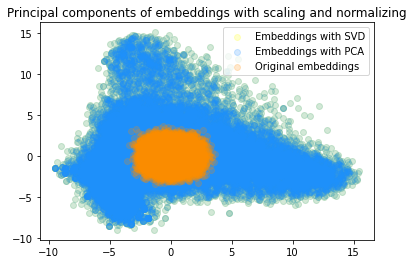

In [41]:
plt.scatter(scaled_svd_embeddings[:, 0], scaled_svd_embeddings[:, 1], color = "yellow", alpha=0.2)
plt.scatter(scaled_pca_embeddings[:, 0], scaled_pca_embeddings[:, 1], color = "dodgerblue", alpha=0.2)
plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1], color = "darkorange", alpha=0.2)
plt.legend(["Embeddings with SVD", "Embeddings with PCA", "Original embeddings"])
plt.title("Principal components of embeddings with scaling and normalizing")

Text(0.5, 1.0, 'Principal components of embeddings without scaling and normalizing')

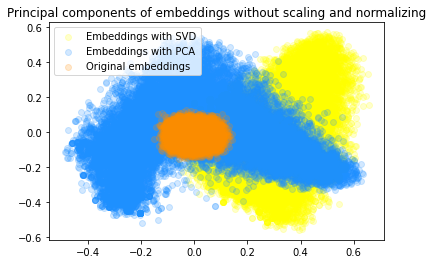

In [42]:
plt.scatter(svd_embeddings[:, 0], svd_embeddings[:, 1], color = "yellow", alpha=0.2)
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], color = "dodgerblue", alpha=0.2)
plt.scatter(embeddings[:, 0], embeddings[:, 1], color = "darkorange", alpha=0.2)
plt.legend(["Embeddings with SVD", "Embeddings with PCA", "Original embeddings"])
plt.title("Principal components of embeddings without scaling and normalizing")

In [45]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

sse_pca_scaled, db_pca_scaled, slc_pca_scaled = {}, {}, {}
for k in range(5, 125, 5):
    print("Clustering with {} clusters...".format(k))
    kmeans_pca = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(scaled_pca_embeddings)
    clusters_pca = kmeans_pca.labels_
    sse_pca_scaled[k] = kmeans_pca.inertia_
    db_pca_scaled[k] = davies_bouldin_score(scaled_pca_embeddings, clusters_pca)
    slc_pca_scaled[k] = silhouette_score(scaled_pca_embeddings, clusters_pca)

Clustering with 5 clusters...
Clustering with 10 clusters...
Clustering with 15 clusters...
Clustering with 20 clusters...
Clustering with 25 clusters...
Clustering with 30 clusters...
Clustering with 35 clusters...
Clustering with 40 clusters...
Clustering with 45 clusters...
Clustering with 50 clusters...
Clustering with 55 clusters...
Clustering with 60 clusters...
Clustering with 65 clusters...
Clustering with 70 clusters...
Clustering with 75 clusters...
Clustering with 80 clusters...
Clustering with 85 clusters...
Clustering with 90 clusters...
Clustering with 95 clusters...
Clustering with 100 clusters...
Clustering with 105 clusters...
Clustering with 110 clusters...
Clustering with 115 clusters...
Clustering with 120 clusters...


In [44]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

sse_pca, db_pca, slc_pca = {}, {}, {}
for k in range(5, 125, 5):
    print("Clustering with {} clusters...".format(k))
    kmeans_pca = KMeans(n_clusters = k, max_iter=1000, random_state=10).fit(pca_embeddings)
    clusters_pca = kmeans_pca.labels_
    sse_pca[k] = kmeans_pca.inertia_
    db_pca[k] = davies_bouldin_score(pca_embeddings, clusters_pca)
    slc_pca[k] = silhouette_score(pca_embeddings, clusters_pca)

Clustering with 5 clusters...
Clustering with 10 clusters...
Clustering with 15 clusters...
Clustering with 20 clusters...
Clustering with 25 clusters...
Clustering with 30 clusters...
Clustering with 35 clusters...
Clustering with 40 clusters...
Clustering with 45 clusters...
Clustering with 50 clusters...
Clustering with 55 clusters...
Clustering with 60 clusters...
Clustering with 65 clusters...
Clustering with 70 clusters...
Clustering with 75 clusters...
Clustering with 80 clusters...
Clustering with 85 clusters...
Clustering with 90 clusters...
Clustering with 95 clusters...
Clustering with 100 clusters...
Clustering with 105 clusters...
Clustering with 110 clusters...
Clustering with 115 clusters...
Clustering with 120 clusters...


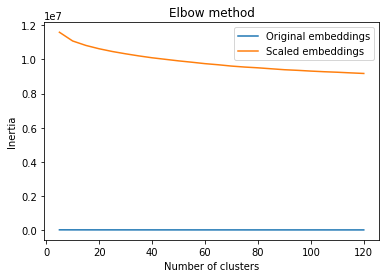

In [75]:
plt.plot(list(sse_pca.keys()), list(sse_pca.values()))
plt.plot(list(sse_pca_scaled.keys()), list(sse_pca_scaled.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.legend(["Original embeddings", "Scaled embeddings"])
plt.show()

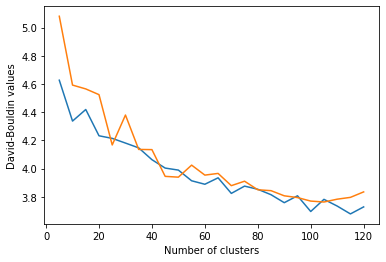

In [49]:
plt.plot(list(db_pca.keys()), list(db_pca.values()))
plt.plot(list(db_pca_scaled.keys()), list(db_pca_scaled.values()))
plt.xlabel("Number of clusters")
plt.ylabel("David-Bouldin values")
plt.show()

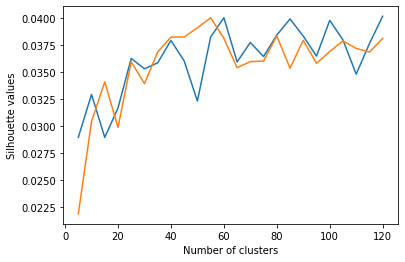

In [50]:
plt.plot(list(slc_pca.keys()), list(slc_pca.values()))
plt.plot(list(slc_pca_scaled.keys()), list(slc_pca_scaled.values()))

plt.xlabel("Number of clusters")
plt.ylabel("Silhouette values")
plt.show()

In [76]:
import umap
reducer2 = umap.UMAP(n_components = 100,min_dist = .5)

embeddings_umap2 = reducer2.fit_transform(pca_embeddings)
embeddings_umap2.shape

(25914, 100)

In [79]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

clustering = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap2)

labels = clustering.labels_
data["labels"] = labels
# measure the performance of dbscan algo
#Identifying which points make up our “core points”
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[clustering.core_sample_indices_] = True
print(core_samples)
#Calculating "the number of clusters"
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(embeddings_umap2, labels))

[ True  True  True ...  True False False]
131
Silhouette Coefficient: -0.453


In [80]:
metrics.silhouette_score(embeddings_umap2, labels)

-0.45255738

In [82]:
reducer2 = umap.UMAP(n_components = 2,min_dist = .5)

embeddings_umap = reducer2.fit_transform(pca_embeddings)
embeddings_umap.shape

(25914, 2)

Text(0.5, 0.98, 'Clustering with DBSCAN')

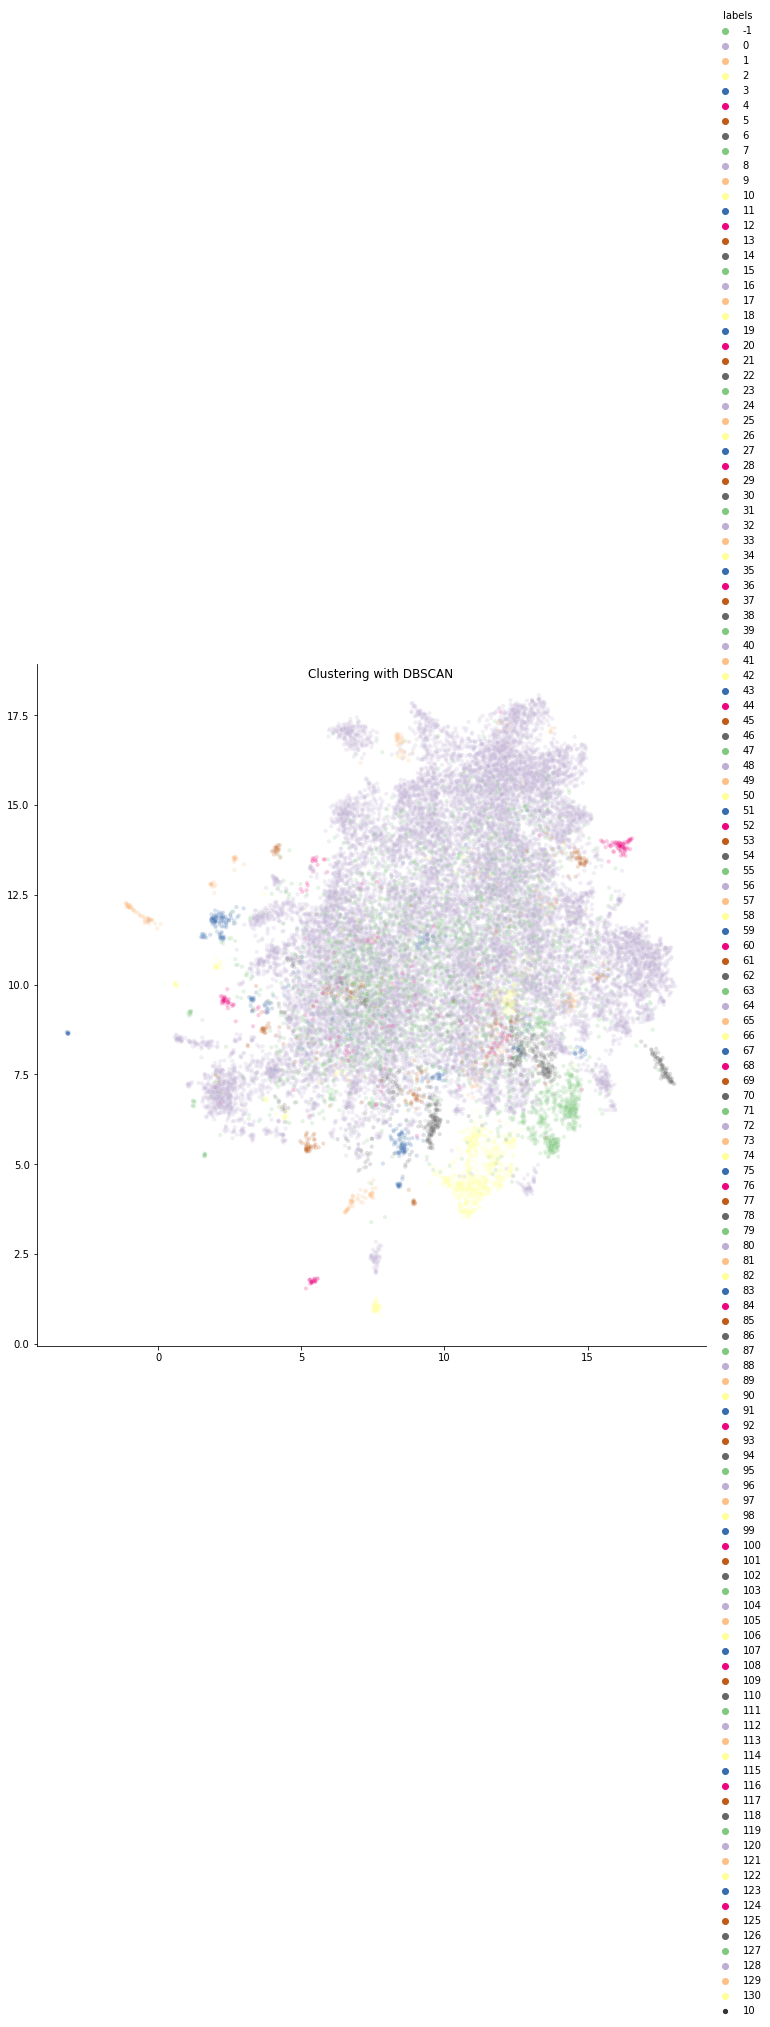

In [83]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2

plot = sns.relplot(x = embeddings_umap[:, 0], y = embeddings_umap[:, 1], size = 10, hue = data["labels"], palette = palette_param,alpha = alpha_param,height = 10)
plot.fig.suptitle('Clustering with DBSCAN')